Internal Bar Strength (IBS) is based on the position of the bar’s close in relation to the bar’s range: 
    it takes a value of 0 if the closing price is the lowest price of the day, and 1 if the closing price is the highest price of the day.
    
 - Formally: $I_t  =  \frac{C_t – L_t}{H_t – L_t}$ 

The essence of the idea is that stocks that close in the lowest part of the bar range, with an IBS of below, say, 0.2, will tend to rally the next bar, while stocks that close in the highest quintile will often decline in value in the following session.

In [2]:
%run ../initlibs.py cryptomomentum dark
from itertools import cycle

In [3]:
def ibs(data):
    """
    IBS indicator
    """
    if isinstance(data, dict):
        return pd.DataFrame.from_dict({k: ibs(v) for k, v in data.items()})
    else: 
        return (data.close - data.low) / (data.high - data.low)
    
def prepare_data(data, timeframe, fwd_bars=6, in_usd=False):
    pdata = ohlc_resample(data, timeframe, resample_tz='UTC')
    i = pd.qcut(ibs(pdata), 10, labels=False)
    
    # fwd_hours hours horizon
    if in_usd:
        r = make_forward_returns_matrix(pdata, fwd_bars, use_usd_rets=True)
    else:
        r = make_forward_returns_matrix(pdata, fwd_bars)
        
    r['H'] = r.index.hour
    r['IBS'] = i
    return r.dropna()

def compound_stats_plot(s):
    """
    Plot compound statistics on plain chart
    """
    w0 = 1; dw0 = 1.1*w0 / s.shape[1]
    
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(i) for i in range(1, 15*len(s.columns), 15)]
    
    for c, cl in zip(s.columns, cycle(colors)):
        plt.bar(s.index, s[c], color=cl, width=w0, label=c)
        w0 -= dw0
        
    plt.xticks(s.index)
    plt.legend(
        bbox_to_anchor=(0., 0, 1., .102), 
        loc='lower left', ncol=len(s.columns), mode="expand", borderaxespad=0.)

def plot_compound_statistics(grp):
    for H in range(24):
        g2 = grp.xs(H, level='H') #[['F1']]
        sbp(83, H+1)
        compound_stats_plot(g2)
        _sy = 1.02 * np.max(abs(g2.values))
        plt.ylim(-_sy, _sy)

        plt.title(f'{H}:00 UTC')
        
def plot_forward_stats_3d(g):
    for H in range(24):
        fig(4,3)
        g2 = g.xs(H, level='H')
        plot_3d_frame(g2, 'IBS Decile', 'Fwd Horizon Hrs', 'Mean returns (pips)', title=f'{H}:00 - {H+1}:00 EET predictability')
        
def plot_separate_hour(g, h, fwd):
    g2 = g.xs(h, level='H')[[fwd]]
    plt.bar(g2.index.values, g2.values.ravel(), color='r', label=fwd)
    _r = max(abs(g2.values))
    plt.ylim(-_r, _r)
    plt.legend()
    
def plot_separate_hour_all(g, h):
    for i,c in enumerate(g.columns):
        sbp(23,i+1)
        plot_separate_hour(g, h, c)
        plt.title(c)

Initially we'd like to see if there is any significance in IBS indicator if we'd use it as mean-reverting predictor. For that we will quantify ibs values into deciles and collect statistics of forward returns (for from 1 to 12 hours in future) for each decile.

In [4]:
instrument = 'BTCUSDT'
data_1m = load_binance_data(instrument, '1m', path=__project_path + '/data')

In [5]:
raw_stat = prepare_data(data_1m, '1H', fwd_bars=12, in_usd=True)

Statistics of forward returns based on IBS indicator's value (it's percentile)

In [6]:
raw_stat.drop(columns=['H']).groupby('IBS').mean()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
IBS,,,,,,,,,,,,
0.0,11.059768,13.898679,17.557731,17.399560,15.369166,19.215829,22.554551,25.741439,25.047445,26.332148,29.419889,30.915516
1.0,4.049472,8.710959,8.098843,11.911588,13.818513,12.703533,13.737594,13.723506,17.696302,20.430400,16.619041,17.209297
2.0,1.931018,4.245267,2.513509,4.240071,2.761946,3.487116,5.466797,7.906783,10.839795,8.242585,6.054003,6.815778
3.0,0.939240,1.234524,3.648759,4.068301,7.321604,9.068554,8.313364,8.783848,9.598069,10.499549,11.891194,12.525903
4.0,0.913950,0.385035,0.905997,0.850161,-0.861983,-1.774151,-1.003654,0.076245,-0.602555,-2.743217,1.396020,-0.717173
5.0,-0.825318,2.232911,3.040692,1.426007,7.259059,7.634007,8.424444,10.025076,11.598454,9.048649,13.080309,11.952235
6.0,-0.398278,-4.748221,-2.465769,-0.917888,-0.019492,2.728917,0.024184,-1.746969,-0.107756,-0.926202,-0.816979,3.057296
7.0,-1.917757,-2.958857,-1.923857,3.808215,5.526775,10.369633,12.211416,13.325094,16.055723,19.696675,18.686217,20.869835
8.0,0.590501,1.804427,5.506770,6.467939,4.548383,4.566787,5.437482,7.816316,6.300521,13.940840,18.093691,21.442333


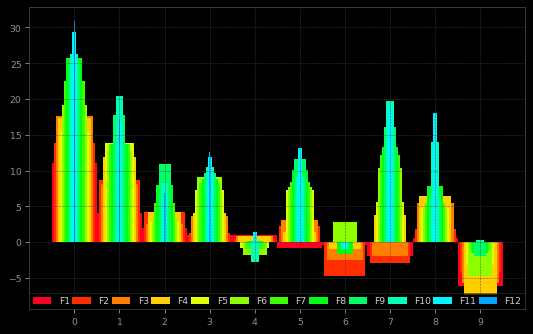

In [7]:
compound_stats_plot(raw_stat.drop(columns=['H']).groupby('IBS').mean())

We can see that when our IBS hits 1'st decile (closing price of 1H bar is near it's low price) it's strong predictor for up movement for next period (from 1H to 12H), and when IBS hits 10'th decile (closing price is near bar's high) we'd observe price declining.

In [8]:
raw_stat_r = prepare_data(data_1m, '1H', fwd_bars=12, in_usd=False)

In [9]:
raw_stat_r.drop(columns=['H']).groupby('IBS').mean()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
IBS,,,,,,,,,,,,
0.0,0.001238,0.001666,0.002025,0.001985,0.001913,0.002301,0.002486,0.002918,0.002784,0.002856,0.003318,0.003343
1.0,0.000588,0.000992,0.000903,0.001055,0.001276,0.001297,0.001346,0.001517,0.001872,0.002199,0.001904,0.002219
2.0,0.000057,0.000286,0.000142,0.000256,0.000214,0.000326,0.000431,0.000519,0.000839,0.000753,0.000523,0.000519
3.0,0.000110,0.000041,0.000225,0.000161,0.000550,0.000716,0.000681,0.000693,0.000868,0.000962,0.001152,0.001307
4.0,0.000135,0.000165,0.000414,0.000543,0.000483,0.000344,0.000520,0.000710,0.000714,0.000626,0.001035,0.000963
5.0,0.000009,0.000206,0.000317,0.000312,0.000794,0.000839,0.000894,0.001083,0.001163,0.000989,0.001207,0.001199
6.0,0.000040,-0.000236,-0.000108,0.000064,0.000127,0.000242,0.000040,-0.000165,-0.000115,-0.000241,-0.000283,-0.000079
7.0,-0.000150,-0.000180,-0.000013,0.000464,0.000561,0.001029,0.001229,0.001307,0.001542,0.001889,0.001873,0.002031
8.0,-0.000007,0.000027,0.000244,0.000272,-0.000007,0.000082,0.000187,0.000358,0.000289,0.000863,0.001236,0.001513


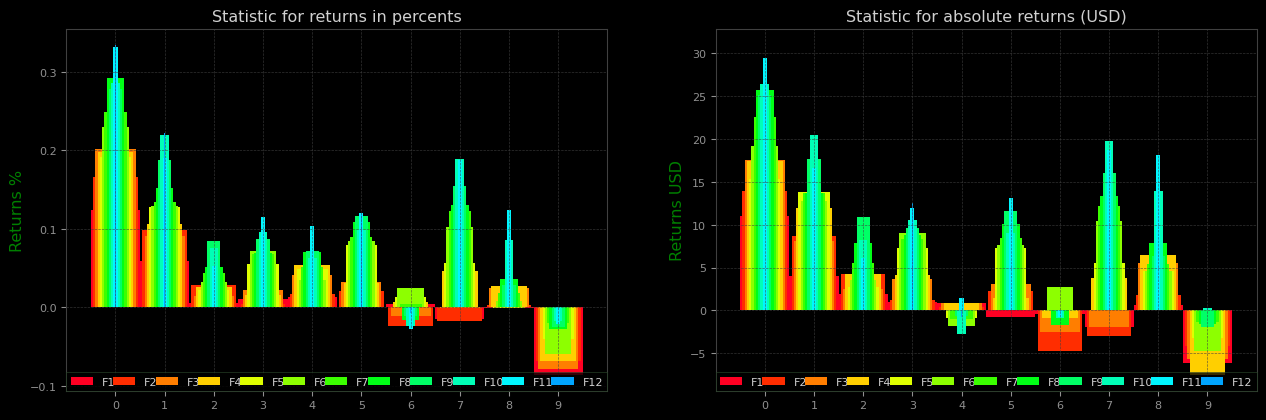

In [11]:
fig(16, 5)
sbp(12,1); compound_stats_plot(100*raw_stat_r.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for returns in percents'); plt.ylabel('Returns %')
sbp(12,2); compound_stats_plot(raw_stat.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for absolute returns (USD)'); plt.ylabel('Returns USD');

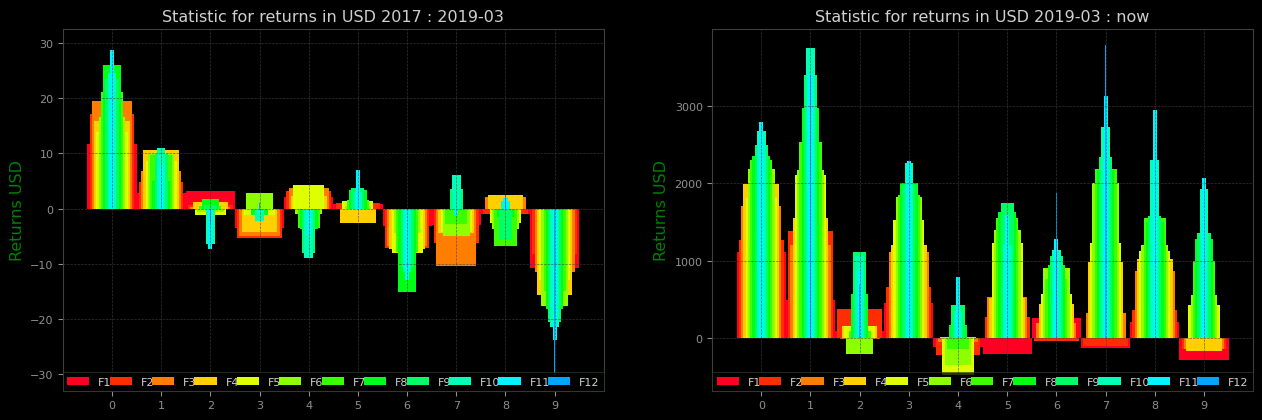

In [12]:
raw_stat_1 = prepare_data(data_1m[:'2019-03-01'], '1H', fwd_bars=12, in_usd=True)
raw_stat_2 = prepare_data(data_1m['2019-03-01':], '1H', fwd_bars=12, in_usd=True)

fig(16, 5)
sbp(12,1); compound_stats_plot(raw_stat_1.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for returns in USD 2017 : 2019-03'); plt.ylabel('Returns USD')

sbp(12,2); compound_stats_plot(100*raw_stat_2.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for returns in USD 2019-03 : now'); plt.ylabel('Returns USD');

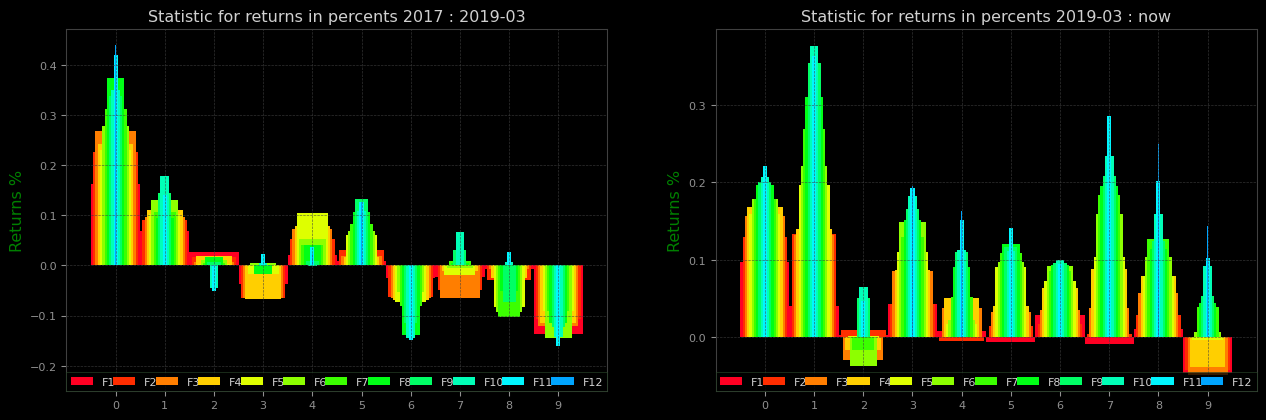

In [13]:
raw_stat_r_1 = prepare_data(data_1m[:'2019-03-01'], '1H', fwd_bars=12, in_usd=False)
raw_stat_r_2 = prepare_data(data_1m['2019-03-01':], '1H', fwd_bars=12, in_usd=False)

fig(16, 5)
sbp(12,1); compound_stats_plot(100*raw_stat_r_1.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for returns in percents 2017 : 2019-03'); plt.ylabel('Returns %')

sbp(12,2); compound_stats_plot(100*raw_stat_r_2.drop(columns=['H']).groupby('IBS').mean()); 
plt.title('Statistic for returns in percents 2019-03 : now'); plt.ylabel('Returns %');

# IBS model

Using this fact we can estimate simple model:
 - buy on next 1H bar open when IBS ~ 1 and flat on bar's close 
 
 - sell on next 1H bar open when IBS ~ 0 and flat on bar's close
 
We are holding position only for 1 hour

In [14]:
def estimate_pnl(bars, T, F=0, Ps=24, sprd=1):
    # volatility filter
    v24 = atr(bars, Ps).shift(1)
    v = atr(bars, 1).shift(1)

    # we operate on next bar
    i = ibs(bars).shift(1)
    iq = pd.qcut(i, 10, labels=False)

    # returns in quoted currency
    f_ret = bars.close - bars.open
    if T is not None:
        sh = -f_ret.loc[i[(i > 1-T) & (v > F * v24)].index] # expect reversion -> short
        lo = +f_ret.loc[i[(i < T) & (v > F * v24)].index]   # expect reversion -> long
    else:
        lo = +f_ret.loc[iq[(iq <= 0) & (v > F * v24)].index]   # expect reversion -> long
        sh = -f_ret.loc[iq[(iq >= 9) & (v > F * v24)].index]   # expect reversion -> short
    pfl = pd.concat((lo, sh), axis=0).sort_index()
    pnl = pd.concat((pfl[pfl >= 0] - sprd, pfl[pfl < 0] - sprd)).sort_index().cumsum()
    return pnl

In [15]:
def find_best_threashold(data, timeframe, spread=1):
    max_sh, best_t = 0, -1

    data_f = ohlc_resample(data, timeframe, resample_tz='UTC')

    for t in tqdm(np.linspace(0.01, 0.25, 20), leave=False):
        p0 = estimate_pnl(data_f, t, sprd=spread)
        sh = p0.diff().mean() / p0.diff().std()
        if sh > max_sh:
            max_sh = sh
            best_t = t
    return best_t

Now we test IBS strategy on different timeframes (from 10 minutes to 1W)

In [ ]:
t2tf = {}
for tf in tqdm(['10Min', '30Min', '1H', '2H', '4H', '6H', '8H', '12H', '1D', '1W']):
    t2tf[tf] = find_best_threashold(data_1m, tf, spread=5)

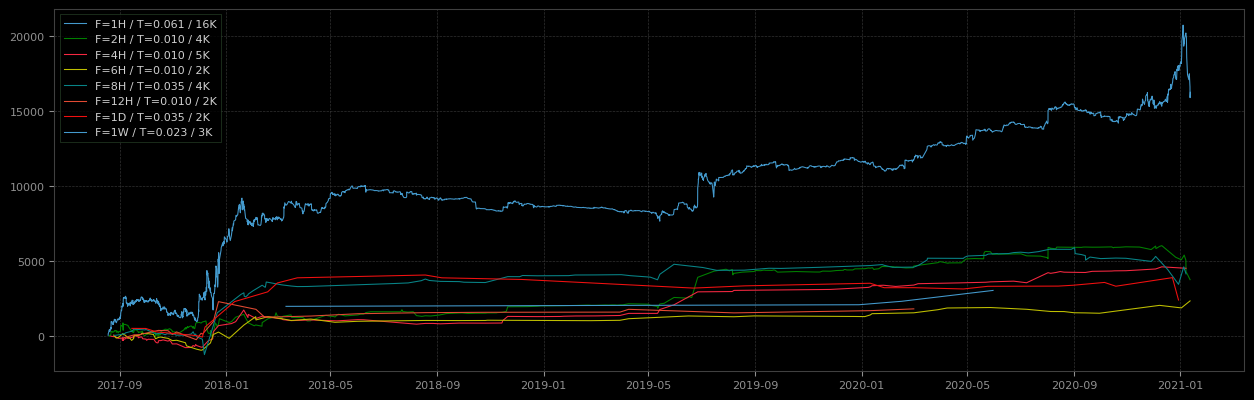

In [17]:
fig(16, 5)
for f,t in t2tf.items():
    if t > 0:
        data_f = ohlc_resample(data_1m, f, resample_tz='UTC')
        p0 = estimate_pnl(data_f, t, sprd=5)
        plt.plot(p0, label=f'F={f} / T={t:0.3f} / {p0[-1]/1000:0.0f}K')
plt.legend(loc=2); 

As we can see optimal threshold is small (as expected) and IBS model generates smaller number of trades for low frequent timeframes ( > 1H). So it's probably woth to stick with 1H.

Also it's strictly dependent on bid-ask spreads

# For every hour in the day

In [18]:
g = raw_stat.groupby(['IBS', 'H']).mean()

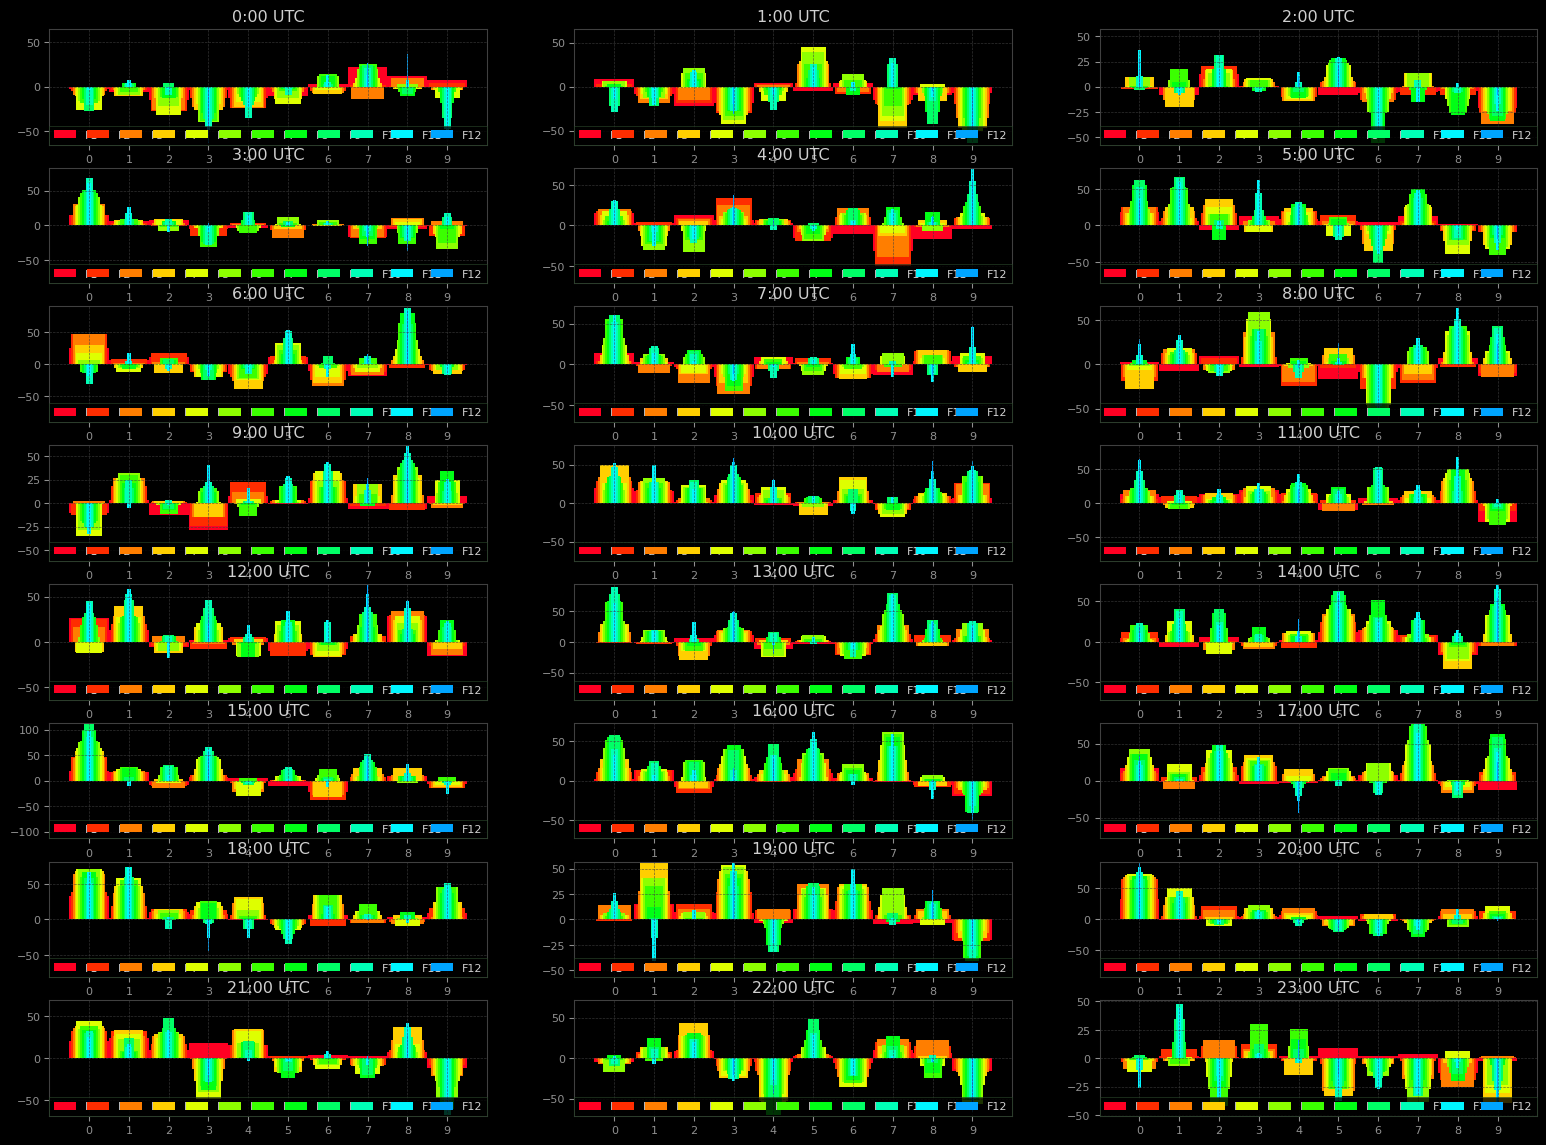

In [19]:
fig(20,15)
plot_compound_statistics(g)

In [20]:
ibs_0,ibs_9 = {}, {}
for h in range(0, 24):
    ibs_0[h] = g.loc[(0.0, h), 'F1'].mean()
    ibs_9[h] = g.loc[(9.0, h), 'F1'].mean()

In [21]:
hds = scols(pd.Series(ibs_0).sort_values(ascending=False).reset_index(), pd.Series(ibs_9).sort_values().reset_index(), names=['Hour', 'IBS[0]', 'Hour', 'IBS[9]'])
hds

,Hour,IBS[0],Hour,IBS[9]
0,20,33.196087,11,-27.981439
1,18,33.117619,2,-21.560093
2,12,26.374800,19,-20.447817
3,6,25.405909,16,-19.161058
4,21,20.965118,22,-15.213553
5,10,20.113621,12,-15.103200
6,15,19.498679,17,-13.041429
7,5,18.133206,8,-12.909811
8,17,17.365273,21,-11.697984
9,4,15.342446,5,-9.316899


Trading hours

In [22]:
def estimate_pnl_hours(bars, T, long_hours, short_hours, sprd=1):
    # we operate on next bar
    i = ibs(bars).shift(1)
    is_long = pd.Series([h in long_hours for h in i.index.hour], i.index)
    is_short = pd.Series([h in short_hours for h in i.index.hour], i.index)
    iq = pd.qcut(i, 10, labels=False)

    # returns in quoted currency
    f_ret = bars.close - bars.open
    if T is not None:
        sh = -f_ret.loc[i[(i > 1-T) & is_short].index] # expect reversion -> short
        lo = +f_ret.loc[i[(i < T) & is_long].index]   # expect reversion -> long
    else:
        lo = +f_ret.loc[iq[(iq <= 0) & is_long].index]   # expect reversion -> long
        sh = -f_ret.loc[iq[(iq >= 9) & is_short].index]   # expect reversion -> short
        
    pfl = pd.concat((lo, sh), axis=0).sort_index()
    pnl = pd.concat((pfl[pfl >= 0] - sprd, pfl[pfl < 0] - sprd)).sort_index().cumsum()
    return pnl

In [23]:
h_lo, h_sh = hds.loc[:9,'Hour'].to_numpy().T

data_1h = ohlc_resample(data_1m, '1h', resample_tz='UTC')
p_hrs = estimate_pnl_hours(data_1h, None,  h_sh, h_lo, sprd=5)
p_all = estimate_pnl(data_1h, None, sprd=5)

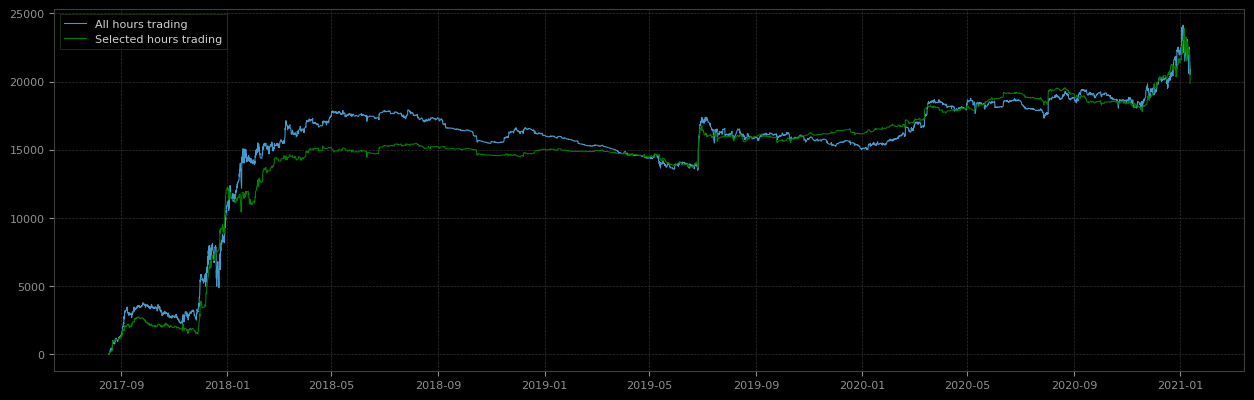

In [24]:
fig(16, 5)
plt.plot(p_all, label='All hours trading')
plt.plot(p_hrs, label='Selected hours trading')
plt.legend();